![](./images/JN_header.jpg)

# On Shaky Ground
---
**Author:**  [Ted Brandon](https://github.com/theobigdog)

## Introduction
---
Most everyone, even those who don't live in prone areas, knows about the awesome, yet devastating power of earthquakes, with caveats of landslides, liquifaction and tsunami.  All of these aspects, combined, form a great threat to human lives, as well as infrastucture, dwellings, businesses, essential utilities such as power and water, etc.,...  On March 11, 2011, a M-9.0 earthquake off the east coast of Japan caused a tsunami that not only wreaked havoc, as described above, but also led to one of the worst nuclear catastrophies the world has seen.  Estimated death count for this event is ~20,000 with an estimation of \\$220 billion USD in damages in Japan alone.  On December 26, 2004, a M-9.1 earthquake off the coast of Sumatra-Andaman caused a tsunami that hit all nearby islands and most nearby countries, including Indonesia, Sri Lanka, India, Maldives and Thailand.  This earthquake resulted in the loss of at least 225,000 human lives, and damages of ~\\$15 billion USD.  January 12, 2010, a M-7.0 earthquake in Haiti caused such excessive damage to person and property that, 10 years later, the country has still not recovered.

## Business Understanding
---
Formed in 2009, The Earthquake Disaster Assistance Team (EDAT) is an international rapid response team under the United States Geological Survey (USGS) umbrella.

## Data Understanding
---
All data come from the Kaggle ["Significant Earthquakes, 1965-2016"](https://www.kaggle.com/usgs/earthquake-database) dataset, which includes the date, time and location of all earthquakes with a magnitude of 5.5 or higher.  The set contains ~23,000 entries with 21 features(columns), including, in addition to the above, such information as type, depth, seismic stations, magnitude types, amongst others.  

In [1]:
# Import the goodies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

Load data into a df, combine `Date` and `Time` to make a new feature, which can then be converted to a "date-time" object.

In [2]:
df = pd.read_csv('data/Significant_Earthquakes_1965-2016.csv')

df['Date_Time'] = df['Date'] + ' ' + df['Time']
df_dt = df.drop('Date', axis=1).drop('Time', axis=1)
dt = df_dt['Date_Time']
df_dt.drop('Date_Time', axis=1, inplace=True)
df_dt = pd.concat([dt, df_dt], axis=1)

#Rows 3378, 7512, 20650 have date-times in a different format, so we'll drop them.
df_dt.drop([3378,7512,20650], inplace=True)

df_dt['Date_Time'] = pd.to_datetime(df_dt['Date_Time'])
df_dt.reset_index(drop=True)
df_dt.head(1)

,Date_Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,1965-01-02 13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic


## Start the EDA process

In [3]:
#dropping all entries that are not actual Earthquakes (no Nuclear Explosions, Explosions or Rock Bursts)
df_eq = df_dt[df_dt['Type'] == 'Earthquake'].reset_index(drop=True)

Multiple columns are missing too much data, so I will drop them here, "Type" is dropped because
all entries are "Earthquake" due to the way the data have thus far been processed.

In [4]:
drop_cols = ['Type','Depth Error','Depth Seismic Stations','Magnitude Error','Magnitude Seismic Stations','Azimuthal Gap',\
            'Horizontal Distance','Horizontal Error','Root Mean Square']
df_trim = df_eq.drop(drop_cols, axis=1)

Summary of usable data:

In [5]:
df_len = len(df)
df_trim_len = len(df_trim)
diff = df_len - df_trim_len
loss = round(diff/df_len*100,2)

print(str(df_len) + ' entries to start.  With cleanup, we now have '\
     + str(df_trim_len) + ' remaining.  This is a loss of ' + str(loss) + '%.')

23412 entries to start.  With cleanup, we now have 23229 remaining.  This is a loss of 0.78%.


## Earthquake Map

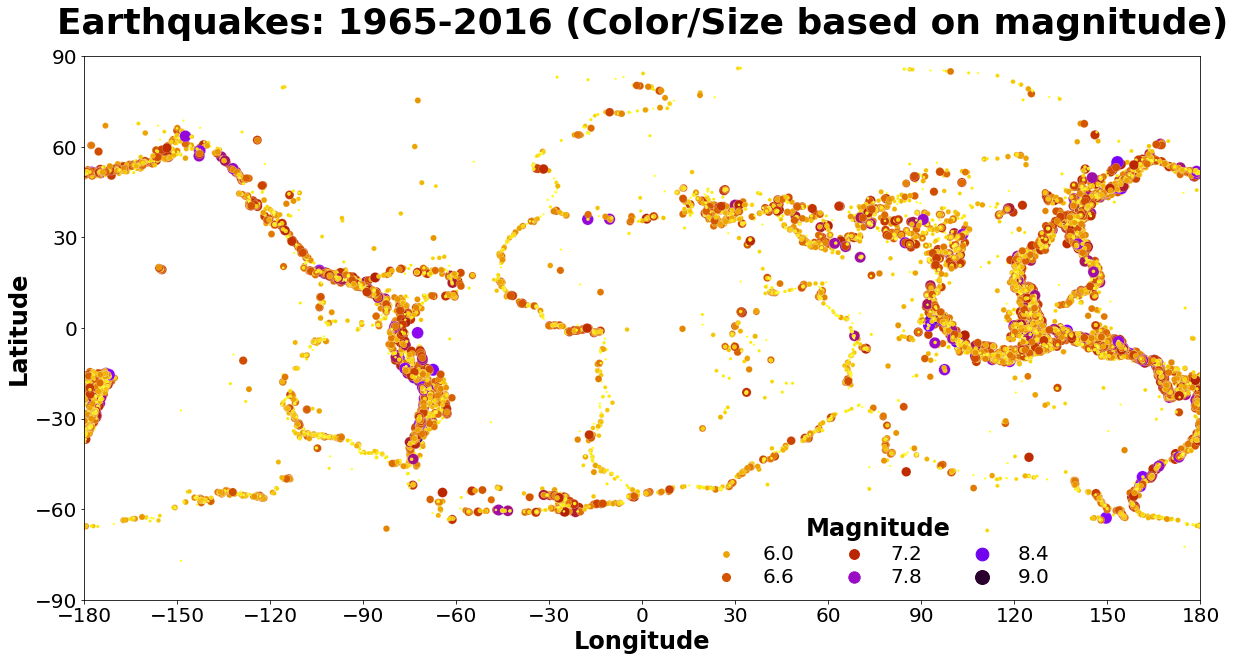

In [6]:
df_trunc = df_trim.copy()
lat_30 = [-90,-60,-30,0,30,60,90]
long_30 = [-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]

fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=df_trunc['Longitude'], y=df_trunc['Latitude'], hue=df_trunc['Magnitude'],
                size=df_trunc['Magnitude'], sizes=(5,200),marker='o',palette='gnuplot_r')
# leg_col = '#f7f7f7' # For overlay
leg_col = 'black' # For notebook
legend = plt.legend(title='Magnitude', title_fontsize=24, fontsize=20, labelspacing=0.2,
                loc=(0.55,0.01), ncol=3, frameon=False, labelcolor=leg_col)
plt.setp(legend.get_title(), color =leg_col, fontweight='bold')
ax.set_ylim([-90,90])
plt.title('Earthquakes: 1965-2016 (Color/Size based on magnitude)', fontsize=36,
          fontweight='bold', y=1.03)
plt.xlabel('Longitude', fontsize=24, fontweight='bold')
plt.yticks(lat_30, fontsize=20)
ax.set_xlim([-180,180])
plt.ylabel('Latitude', fontsize=24, fontweight='bold')
plt.xticks(ticks=(long_30), fontsize=20);
# plt.savefig('images/earthquake_map_presentation.png', transparent=True, dpi=300) # Export for presentation
# plt.savefig('images/earthquake_map_notebook.png', dpi=300) # Export for notebook

## Feature Engineering

I want to see if binning this by month or season will provide useful information.

In [7]:
df_binned = df_trunc.copy()
df_binned['Month'] = pd.DatetimeIndex(df_binned['Date_Time']).month

season = {1 : 'Winter', 2 : 'Winter', 3 : 'Spring', 4 : 'Spring', 5 : 'Spring', 6 : 'Summer',
         7 : 'Summer', 8 : 'Summer', 9 : 'Fall', 10 : 'Fall', 11 : 'Fall', 12 : 'Winter'}

df_binned['Season'] = df_binned['Month'].map(season)

## Country names were generated, based on Lats/Longs

Since I will eventually pare this down to just Asian countries, the next two blocks of code were written to identify the country that experienced a given earthquake.  The first step makes a new column, `Geocode`, as a list of tuples of `Latitude` and `Longitude`.  Then `reverseGeocode` and `country_converter` are combined to generate a `Country` column.

The `reverseGeocode` step took about 4hr to complete, so these results were backed-up as a csv.  Future importing of this csv allows for these time-demanding steps to be bypassed.

In [8]:
df_lat_long = df_binned.copy()
lat_long = []
for i in range(len(df_lat_long['Latitude'])):
    lat_long.append((df_lat_long['Latitude'][i], df_lat_long['Longitude'][i]))
df_lat_long['Geocode'] = lat_long

In [9]:
# This was only used once to create the "official_countries.csv" file.  Do not use again.

# # !pip install reverse_geocoder
# import reverse_geocoder as rg
# # !pip install country_converter
# import country_converter as coco

# # def reverseGeocode(coordinates):
#    # result = rg.search(coordinates)
#    # return coco.convert(names=result[0]['cc'], to='name_short')

# df_geocode = df_lat_long.copy()
# df_geocode['Country'] = df_geocode['Geocode'].apply(reverseGeocode)

# df_geocode.to_csv('data/official_countries.csv')

In [10]:
df_countries = pd.read_csv('data/official_countries.csv')

### Now we can identify each earthquake that occurred in asia, by using the following function to check for inclusion in a [list of asian countries](https://www.countries-ofthe-world.com/countries-of-asia.html):

In [11]:
def is_asian(country):
    asia = ['Afghanistan','Armenia','Azerbaijan','Bahrain','Bangladesh','Bhutan','Brunei',
           'Cambodia','China','Cyprus','Georgia','India','Indonesia','Iran','Iraq','Israel',
           'Japan','Jordan','Kazakhstan','Kuwait','Kyrgyzstan','Laos','Lebanon','Malaysia',
           'Maldives','Mongolia','Myanmar','Nepal','North Korea','Oman','Pakistan','Palestine',
           'Philippines','Qatar','Russia','Saudi Arabia','Singapore','South Korea','Sri Lanka',
           'Syria','Taiwan','Tajikistan','Thailand','Timor-Leste','Turkey','Turkmenistan','UAE',
           'United Arab Emirates','United Arab Emirates (UAE)','Uzbekistan','Vietnam','Yemen']
    if country in asia:
        asian = 1
    else:
        asian = 0
    return asian

df_countries['In_Asia'] = df_countries['Country'].apply(is_asian)

In [12]:
total_earthquakes = len(df_countries)
asian_earthquakes = df_countries['In_Asia'].value_counts()[1]
non_asian_earthquakes = df_countries['In_Asia'].value_counts()[0]
percent_asian = round(df_countries['In_Asia'].value_counts('1')[1] * 100, 2)

print('There are ' + str(total_earthquakes) + ' earthquakes in the initial data set.')
print(str(asian_earthquakes) + ' of these occurred in Asian countries,')
print('leaving ' + str(non_asian_earthquakes) + ' occurring in the rest of the world.')
print('This means that earthquakes in Asia accounted for ' + str(percent_asian) + '% of the\
 world total from 1965 through 2016.')

There are 23229 earthquakes in the initial data set.
8859 of these occurred in Asian countries,
leaving 14370 occurring in the rest of the world.
This means that earthquakes in Asia accounted for 38.14% of the world total from 1965 through 2016.


In [13]:
df_asian = df_countries[df_countries['In_Asia'] == 1].reset_index(drop=True)

In [14]:
#  Oops!  Extra "index" column from the "big" engineered feature.  Dropping:

drop_extra = ['Unnamed: 0']
df_asian = df_asian.drop(drop_extra, axis=1)

### Plot of Asian Earthquakes

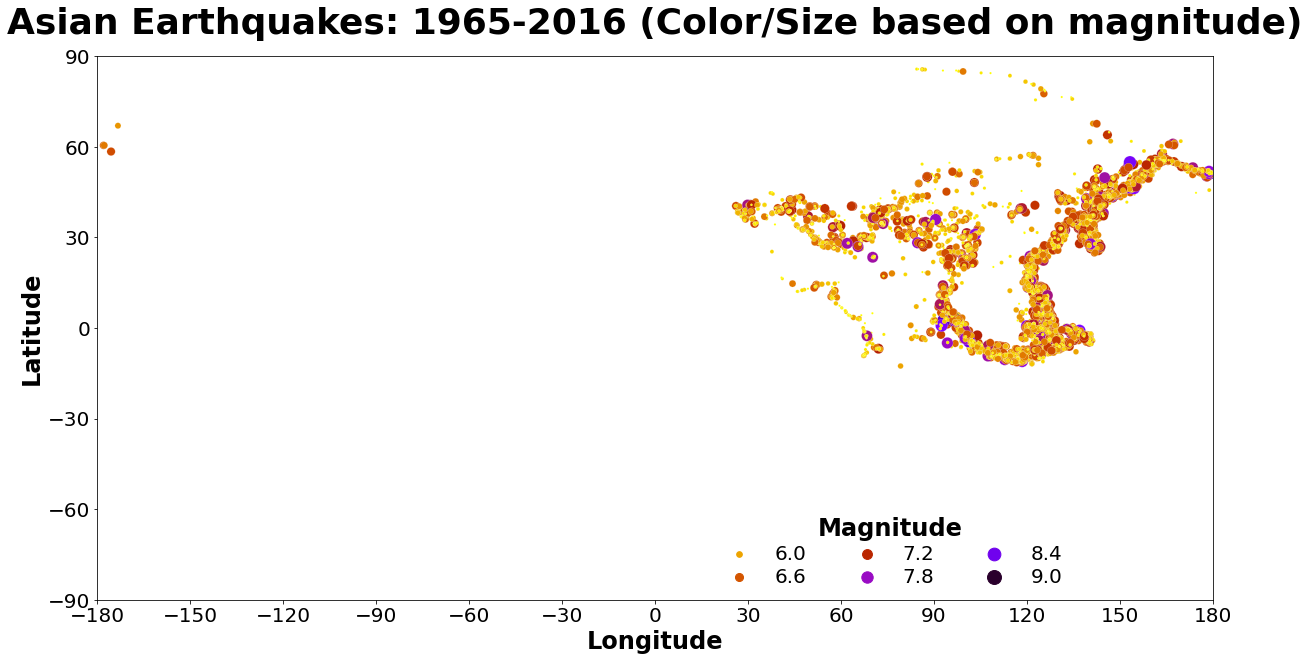

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=df_asian['Longitude'], y=df_asian['Latitude'], hue=df_asian['Magnitude'],
                size=df_asian['Magnitude'], sizes=(5,200),marker='o',palette='gnuplot_r')
# leg_col = '#f7f7f7' # For overlay
leg_col = 'black' # For notebook
legend = plt.legend(title='Magnitude', title_fontsize=24, fontsize=20, labelspacing=0.2,
                loc=(0.55,0.01), ncol=3, frameon=False, labelcolor=leg_col)
plt.setp(legend.get_title(), color =leg_col, fontweight='bold')
ax.set_ylim([-90,90])
plt.title('Asian Earthquakes: 1965-2016 (Color/Size based on magnitude)', fontsize=36,
          fontweight='bold', y=1.03)
plt.xlabel('Longitude', fontsize=24, fontweight='bold')
plt.yticks(lat_30, fontsize=20)
ax.set_xlim([-180,180])
plt.ylabel('Latitude', fontsize=24, fontweight='bold')
plt.xticks(ticks=(long_30), fontsize=20);
# plt.savefig('images/asian_earthquake_map_presentation.png', transparent=True, dpi=300) # Export for presentation
# plt.savefig('images/asian_earthquake_map_notebook.png', dpi=300) # Export for notebook

## Let's start the time-series modeling process

Somehow, the Date_Time column was re-converted to "object" so I'll fix that now:

In [16]:
df_asian['Date_Time'] = pd.to_datetime(df_asian['Date_Time']).reset_index(drop=True)

In [17]:
# Creating the actual time-series of Asian earthquakes:
asian_ts = pd.Series(df_asian.set_index(df_asian['Date_Time'])['Magnitude'])

# Let's resample to Monthly sum and see how it looks
monthly_sum_asian = asian_ts.resample('MS').sum()

# We'll also make a Monthly mean, which is the series that will be analyzed/processed
monthly_mean_asian = asian_ts.resample('MS').mean()

Let's visualize those monthly resamplings

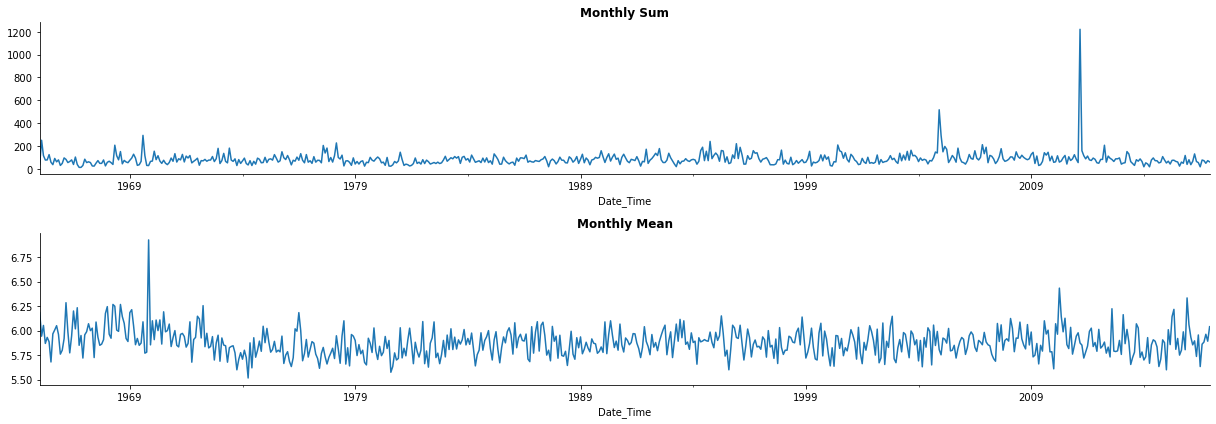

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(17,6), tight_layout=True)

ax = axs[0]
monthly_sum_asian.plot(ax=ax)
ax.set_title('Monthly Sum', fontweight='bold')
sns.despine(top=True,right=True)
ax=axs[1]
monthly_mean_asian.plot(ax=ax)
ax.set_title('Monthly Mean', fontweight='bold')
sns.despine(top=True,right=True);

Not a ton of info here.  Looking at the mean, it does appear to be stationary, but we'll give it a Dickey-Fuller test to make sure.

#### Dickey-Fuller

In [19]:
from statsmodels.tsa.stattools import adfuller

def run_df(ts):
    df_rslt = adfuller(ts)
    print("Dickey_Fuller test results:  \n")
    df_output = pd.Series(df_rslt[0:4], index=['Test Statistic','p-value',\
                                              '#Lags Used','Number of Observations Used'])
    for key, value in df_rslt[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)
    print()
    if df_output['p-value'] < 0.05 and df_output['Test Statistic'] < -3.43: # -3.43 was the best I could find, on Wikipedia
        print('With ', len(ts), ' data points, a p-value of ', round(df_output['p-value'],7),'(<0.05) and a DFt of ',
              round(df_output['Test Statistic'],3),', the Null Hypothesis can be rejected and there appears to be stationarity.')
    elif df_output['p-value'] >= 0.05:
        print('p-value greater than 0.05:  ', df_output['p-value'])
    else:
        print('Failed to reject the Null Hypothesis and there appears to be a lack of stationarity.')

There do not appear to be any trends in the data, so I believe we're only looking for stationarity here.

In [20]:
run_df(monthly_mean_asian)

Dickey_Fuller test results:  

Test Statistic                  -3.110476
p-value                          0.025788
#Lags Used                      18.000000
Number of Observations Used    605.000000
Critical Value (1%)             -3.441205
Critical Value (5%)             -2.866329
Critical Value (10%)            -2.569320
dtype: float64

Failed to reject the Null Hypothesis and there appears to be a lack of stationarity.


## FSM with Monthly Means

### Train/Test Split:
For time-series, random sampling doesn't work; data must be continuous.  Therefore, the chronological first 80% of time-series is defined as the train, and the last 20% is defined as the test.

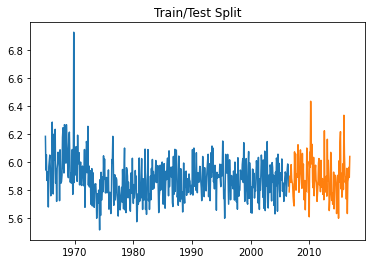

In [21]:
cutoff = round(monthly_mean_asian.shape[0] * 0.8)
train = monthly_mean_asian[:cutoff]
test = monthly_mean_asian[cutoff:]

fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train/Test Split');

In [22]:
random_walk = train.shift(1)

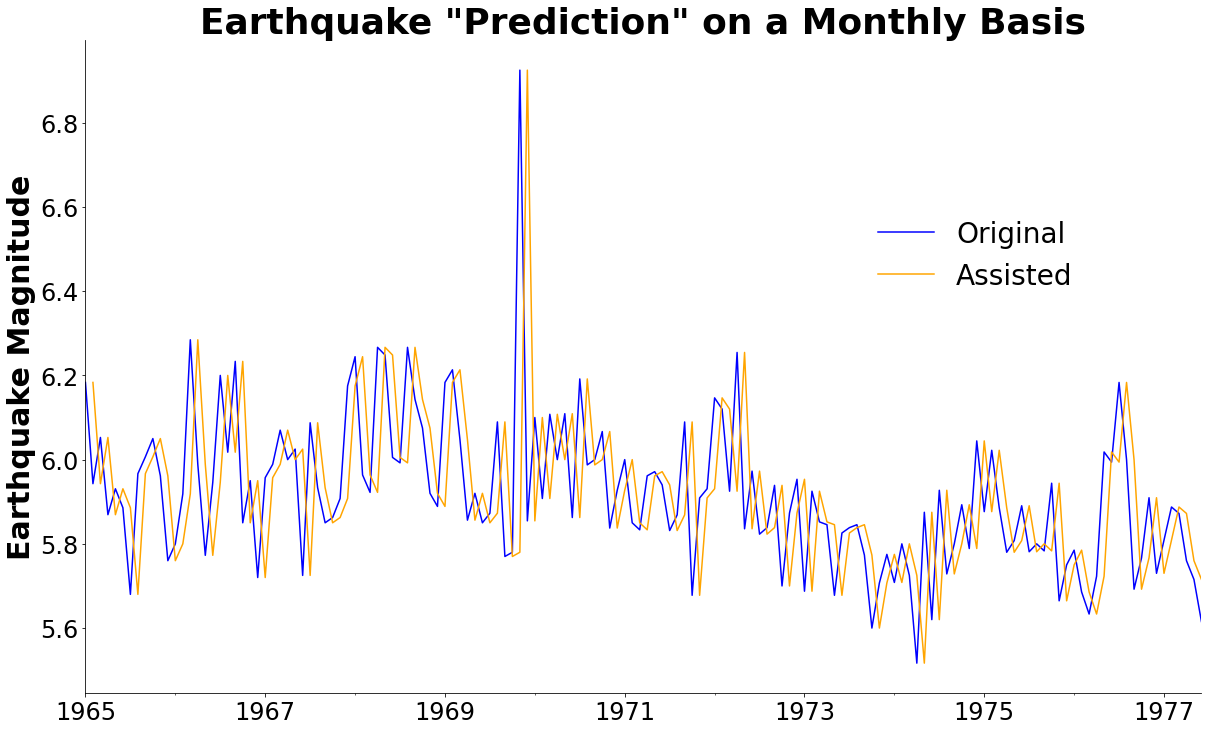

In [23]:
fig, ax = plt.subplots(figsize=(20,12))

train[0:150].plot(ax=ax, c='blue', label='Original')
random_walk[0:150].plot(ax=ax, c='orange', label='Assisted')
ax.set_title('Earthquake "Prediction" on a Monthly Basis', fontsize=36, fontweight='bold')
sns.despine(right=True,top=True)
plt.ylabel('Earthquake Magnitude', fontsize=30, fontweight='bold')
plt.yticks(fontsize=24)
plt.xlabel('')
plt.xticks(fontsize=24)
ax.legend(fontsize=28,loc=(0.7,0.6), frameon=False);
# plt.savefig('images/random_walk.png', dpi=300)

In [24]:
np.sqrt(mean_squared_error(train.dropna()[1:], random_walk.dropna()))

0.18229373618797942

In [25]:
residuals = random_walk[1:] - train[1:]
mse = (residuals**2).sum()/len(residuals-1)
np.sqrt(mse)

0.18229373618797942

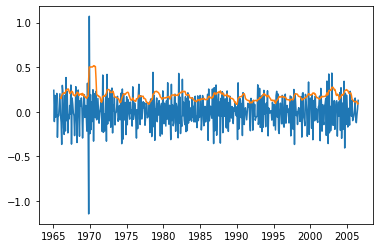

In [26]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(12).std());

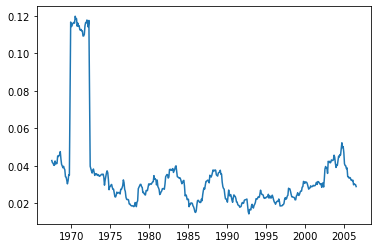

In [27]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

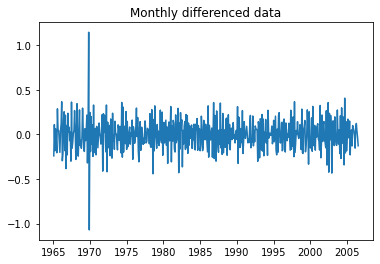

In [28]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Monthly differenced data');

# ARIMA
##### AR:  The prediction that today will be like previous days, with statsmodels object "p"
##### MA:  Moving average, accounts for short-run autocorrelation, with statsmodels object "q"
             "q" can be estimated from ACF plots
### (in an effort to save space, the "summary" lines are commented out)

In [29]:
rw = ARIMA(train, order=(0,1,0)).fit()
y_hat_rw = rw.predict(typ='levels')
rw_rmse = np.sqrt(mean_squared_error(train, y_hat_rw))

In [30]:
ar = ARIMA(train, order=(1,0,0)).fit()
y_hat_ar = ar.predict(typ='levels')
ar_rmse = np.sqrt(mean_squared_error(train, y_hat_ar))

In [31]:
ari_1 = ARIMA(train, order=(1,1,0)).fit()
y_hat_ari1 = ari_1.predict(typ='levels')
ari_1_rmse = np.sqrt(mean_squared_error(train, y_hat_ari1))

In [32]:
ari_2 = ARIMA(train, order=(2,1,0)).fit()
y_hat_ari2 = ari_2.predict(typ='levels')
ari_2_rmse = np.sqrt(mean_squared_error(train, y_hat_ari2))

In [33]:
ma = ARIMA(train, order=(0,0,1)).fit()
y_hat_ma = ma.predict(typ='levels')
ma_rmse = np.sqrt(mean_squared_error(train, y_hat_ma))

In [34]:
ima_1 = ARIMA(train, order=(0,1,1)).fit()
y_hat_ima1 = ima_1.predict(typ='levels')
ima_1_rmse = np.sqrt(mean_squared_error(train, y_hat_ima1))

In [35]:
ima_2 = ARIMA(train, order=(0,1,2)).fit()
y_hat_ima2 = ima_2.predict(typ='levels')
ima_2_rmse = np.sqrt(mean_squared_error(train, y_hat_ima2))

In [36]:
arima_1 = ARIMA(train, order=(1,1,1)).fit()
y_hat_arima1 = arima_1.predict(typ='levels')
arima_1_rmse = np.sqrt(mean_squared_error(train, y_hat_arima1))

In [37]:
print('RW RMSE:', round(rw_rmse, 4),' AIC:', round(rw.aic,3))
print('AR RMSE:', round(ar_rmse, 4),' AIC:', round(ar.aic,3))
print('ARI1 RMSE:', round(ari_1_rmse, 4),' AIC:', round(ari_1.aic,3))
print('ARI2 RMSE:', round(ari_2_rmse, 4),' AIC:', round(ari_2.aic,3))
print('MA RMSE:', round(ma_rmse, 4),' AIC:', round(ma.aic,3))
print('IMA1 RMSE:', round(ima_1_rmse, 4),' AIC:', round(ima_1.aic,3))
print('IMA2 RMSE:', round(ima_2_rmse, 4),' AIC:', round(ima_2.aic,3))
print('ARIMA1 RMSE:', round(arima_1_rmse, 4),' AIC:', round(arima_1.aic,3))

RW RMSE: 0.3313  AIC: -280.065
AR RMSE: 0.1396  AIC: -543.371
ARI1 RMSE: 0.3193  AIC: -412.07
ARI2 RMSE: 0.3153  AIC: -462.534
MA RMSE: 0.1399  AIC: -540.552
IMA1 RMSE: 0.3075  AIC: -585.472
IMA2 RMSE: 0.3075  AIC: -583.491
ARIMA1 RMSE: 0.3075  AIC: -583.49


From the above results, the AR (1,0,0) shows the lowest RMSE (0.1396) and lowest AIC (-543.371) with the MA (0,0,1) following closeby

## ACF and PACF

F:\Flatiron\Anaconda2\envs\learn-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


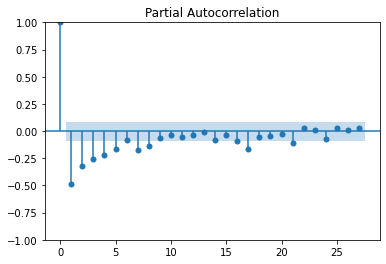

In [38]:
plot_pacf(train.diff().dropna());

F:\Flatiron\Anaconda2\envs\learn-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


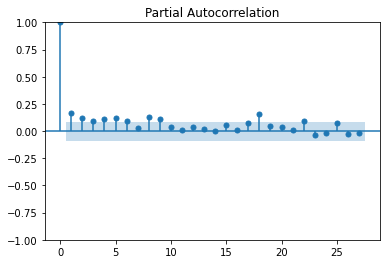

In [39]:
plot_pacf(train);

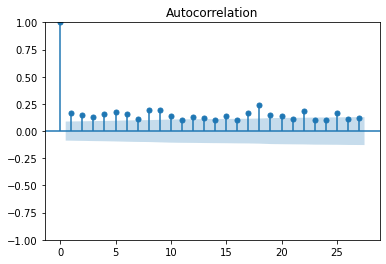

In [40]:
plot_acf(train);

In [41]:
df_lag = pd.DataFrame(train)
df_lag.columns = ['lag_0']
df_lag['lag_1'] = train.shift()
df_lag.head()

,lag_0,lag_1
Date_Time,,
1965-01-01,6.183333,NaN
1965-02-01,5.942857,6.183333
1965-03-01,6.052632,5.942857
1965-04-01,5.869231,6.052632
1965-05-01,5.930769,5.869231


In [42]:
gamma_1 = sum(((df_lag['lag_0'][1:]-df_lag['lag_0'][1:].mean()) *\
               (df_lag['lag_1'].dropna()-df_lag['lag_1'].dropna().mean())))/(len(df_lag['lag_1'])-1)
gamma_1

0.003368835228903461

In [43]:
rho = gamma_1/(df_lag.lag_0[1:].std(ddof=0)*df_lag.lag_1.std(ddof=0))
rho

0.16857763428616113

In [44]:
df_lag = pd.DataFrame(train)
df_lag.columns = ['lag_0']
df_lag['lag_1'] = train.shift()
df_lag['lag_2'] = train.shift(2)
df_lag['lag_3'] = train.shift(3)
df_lag['lag_4'] = train.shift(4)
df_lag['lag_5'] = train.shift(5)
df_lag.corr()

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5
lag_0,1.000000,0.168578,0.147009,0.131805,0.156672,0.177043
lag_1,0.168578,1.000000,0.169033,0.147640,0.132188,0.156452
lag_2,0.147009,0.169033,1.000000,0.168329,0.147174,0.132678
lag_3,0.131805,0.147640,0.168329,1.000000,0.167716,0.147870
lag_4,0.156672,0.132188,0.147174,0.167716,1.000000,0.168157
lag_5,0.177043,0.156452,0.132678,0.147870,0.168157,1.000000


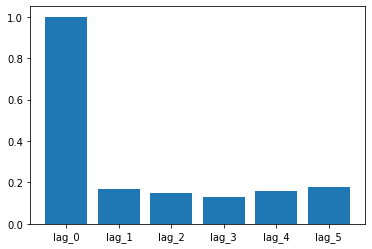

In [45]:
list(df_lag.corr()['lag_0'].index)
plt.bar(list(df_lag.corr()['lag_0'].index), list(df_lag.corr()['lag_0']));

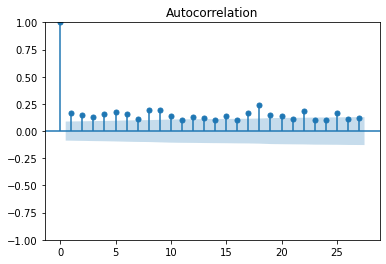

In [46]:
plot_acf(train);

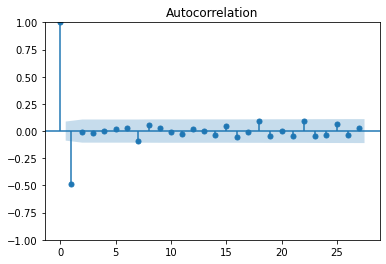

In [47]:
plot_acf(train.diff().dropna());

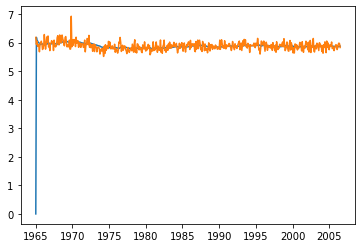

In [48]:
y_hat_train = y_hat_ima1
fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train);

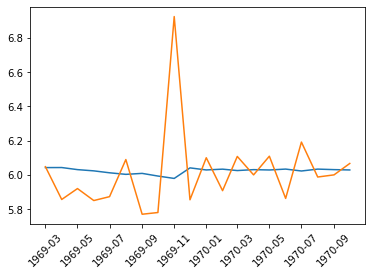

In [49]:
fig, ax = plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70])
plt.xticks(rotation=45);

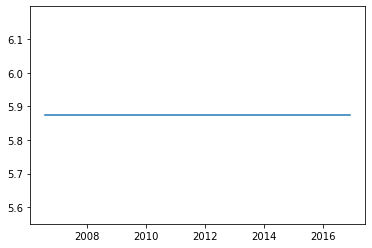

In [50]:
y_hat_test = ima_1.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_test);

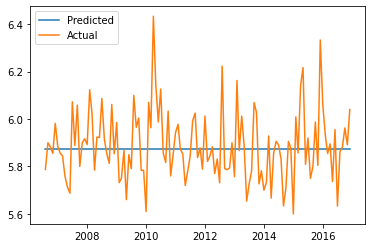

In [51]:
fig, ax = plt.subplots()
ax.plot(y_hat_test)
ax.plot(test)
ax.legend(labels = ['Predicted','Actual']);

In [52]:
test_rmse = np.sqrt(mean_squared_error(test, y_hat_test))
test_rmse

0.14537754752700982

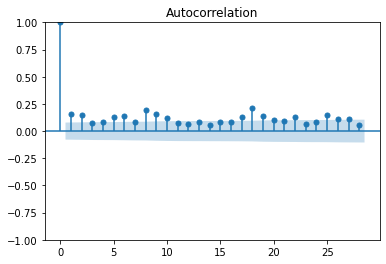

In [53]:
plot_acf(monthly_mean_asian);

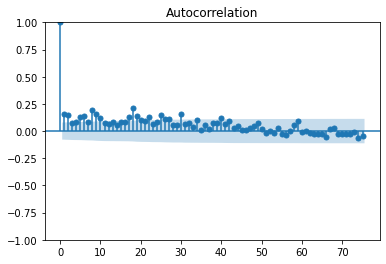

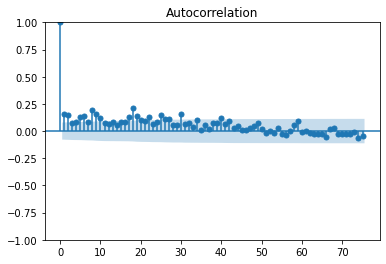

In [54]:
plot_acf(monthly_mean_asian, lags=75)

#### Automated "optimizer" for SARIMA selecting parameters p, d, q and P, D, Q

In [55]:
# # Only run once to optimize

# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameters for SARIMA...')
# for i in pdq:  ##  Only turn on when optimizing
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i, s))

#### Automated SARIMA calculator based on above generated list.  The dict helps expedite examining results.

In [56]:
# Only run once to find optimized parameters

# SARIMAX_dict1 = {'stats':[],'aic':[]} # Dictionary mackes it easy to look through results when finished
# for param in pdq:  # Only run again if we need to re-optimize
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(train,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             SARIMAX_dict1['stats'].append('ARIMA{}x{}'.format(param,param_seasonal))
#             SARIMAX_dict1['aic'].append(results.aic)
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue
# df_sar = pd.DataFrame(SARIMAX_dict1)
# df_sar.to_csv('data/SARIMAX_dict1.csv')

Used to display the parameters with the lowest AIC

In [57]:
df_sar = pd.read_csv('data/SARIMAX_dict1.csv')
df_sar.sort_values('aic').head(10)
df_sar.head(10)

,Unnamed: 0,stats,aic
0,0,"ARIMA(0, 0, 0)x(0, 0, 0, 12)",3179.741723
1,1,"ARIMA(0, 0, 0)x(0, 0, 1, 12)",2495.021502
2,2,"ARIMA(0, 0, 0)x(0, 0, 2, 12)",1921.468264
3,3,"ARIMA(0, 0, 0)x(0, 1, 0, 12)",-248.932838
4,4,"ARIMA(0, 0, 0)x(0, 1, 1, 12)",-478.518119
5,5,"ARIMA(0, 0, 0)x(0, 1, 2, 12)",-466.562140
6,6,"ARIMA(0, 0, 0)x(0, 2, 0, 12)",276.059186
7,7,"ARIMA(0, 0, 0)x(0, 2, 1, 12)",-200.303284
8,8,"ARIMA(0, 0, 0)x(0, 2, 2, 12)",-393.537728
9,9,"ARIMA(0, 0, 0)x(1, 0, 0, 12)",-244.573074


Let's try the parameters with the best AIC scores:

(0,0,1),(0,0,0,12) RMSE:
train:   0.30741824635588777
test:  0.14536558701365163


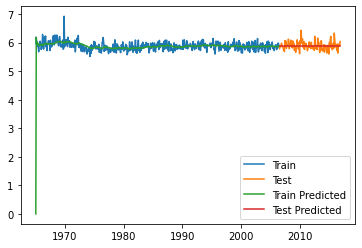

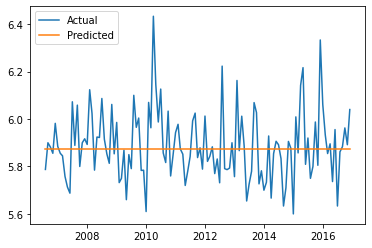

In [58]:
sari_mod =SARIMAX(train,
                  order=(0,1,1),
                  seasonal_order=(0, 0, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')
rmse_011_train = np.sqrt(mean_squared_error(train,y_hat_train))
rmse_011_test = np.sqrt(mean_squared_error(test,y_hat_test))
print('(0,0,1),(0,0,0,12) RMSE:')
print('train:  ',rmse_011_train)
print('test: ',rmse_011_test)

fig, ax = plt.subplots()
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.plot(y_hat_train, label='Train Predicted')
ax.plot(y_hat_test, label='Test Predicted')

plt.legend();

fig, ax = plt.subplots()

ax.plot(test, label='Actual')
ax.plot(y_hat_test, label='Predicted')

plt.legend();

(1,0,1),(0,0,0,12) RMSE:
train:  0.30740734690550386
test:  0.14756540419918554


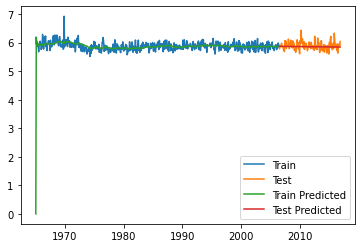

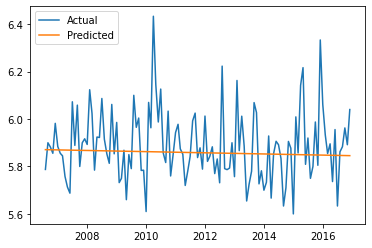

In [59]:
sari_mod =SARIMAX(train,
                  order=(1,0,1),
                  seasonal_order=(0, 0, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')
rmse_101_train = np.sqrt(mean_squared_error(train,y_hat_train))
rmse_101_test = np.sqrt(mean_squared_error(test,y_hat_test))
print('(1,0,1),(0,0,0,12) RMSE:')
print('train: ',rmse_101_train)
print('test: ',rmse_101_test)

fig, ax = plt.subplots()
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.plot(y_hat_train, label='Train Predicted')
ax.plot(y_hat_test, label='Test Predicted')

plt.legend();

fig, ax = plt.subplots()

ax.plot(test, label='Actual')
ax.plot(y_hat_test, label='Predicted')

plt.legend();

(1,0,0),(0,0,0,12) RMSE:
train:   0.3313190171355447
test:  0.33118950966851846


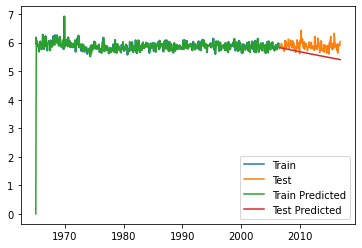

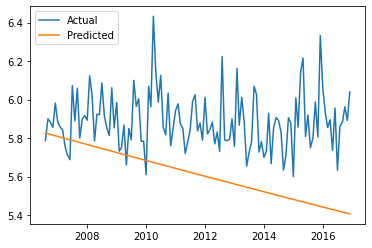

In [60]:
sari_mod =SARIMAX(train,
                  order=(1,0,0),
                  seasonal_order=(0, 0, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')
rmse_100_train = np.sqrt(mean_squared_error(train,y_hat_train))
rmse_100_test = np.sqrt(mean_squared_error(test,y_hat_test))
print('(1,0,0),(0,0,0,12) RMSE:')
print('train:  ',rmse_100_train)
print('test: ',rmse_100_test)

fig, ax = plt.subplots()
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.plot(y_hat_train, label='Train Predicted')
ax.plot(y_hat_test, label='Test Predicted')

plt.legend();

fig, ax = plt.subplots()

ax.plot(test, label='Actual')
ax.plot(y_hat_test, label='Predicted')

plt.legend();

(1,1,0),(0,0,0,12) RMSE:
train:   0.32410360577891034
test:  0.1457589110758973


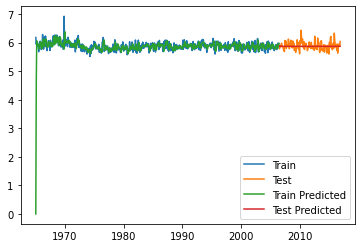

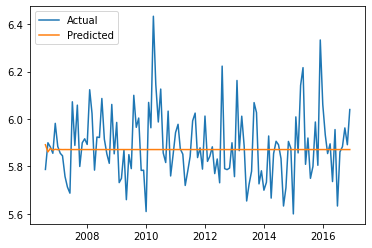

In [61]:
sari_mod =SARIMAX(train,
                  order=(1,1,0),
                  seasonal_order=(0, 0, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')
rmse_110_train = np.sqrt(mean_squared_error(train,y_hat_train))
rmse_110_test = np.sqrt(mean_squared_error(test,y_hat_test))
print('(1,1,0),(0,0,0,12) RMSE:')
print('train:  ',rmse_110_train)
print('test: ',rmse_110_test)

fig, ax = plt.subplots()
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.plot(y_hat_train, label='Train Predicted')
ax.plot(y_hat_test, label='Test Predicted')

plt.legend();

fig, ax = plt.subplots()

ax.plot(test, label='Actual')
ax.plot(y_hat_test, label='Predicted')

plt.legend();

In [62]:
# def binning(time_series):
#     Magn = {'<6':0,'>=6,<6.5':0,'>=6.5,<7':0,'>=7,<7.5':0,'>=7.5':0}
#     for entry in time_series:
#         if entry < 6:
#             Magn['<6'] += 1
#         elif entry >= 6 and entry < 6.5:
#             Magn['>=6,<6.5'] += 1
#         elif entry >=6.5 and entry < 7:
#             Magn['>=6.5,<7'] += 1
#         elif entry >= 7 and entry < 7.5:
#             Magn['>=7,<7.5'] += 1
#         else:
#             Magn['>=7.5'] += 1
#     return Magn
# train_breakdown = binning(train)
# test_breakdown = binning(test)
# train_len = len(train)
# test_len = len(test)
# for magn_range in train_breakdown:
#     print("Train " + str(magn_range) + ':  ' + str(train_breakdown[magn_range]) + ', ' + str(round((train_breakdown[magn_range]/train_len*100),2)) + "%")
# print()
# for magn_range in test_breakdown:
#     print("Test " + str(magn_range) + ':  ' + str(test_breakdown[magn_range]) + ', ' + str(round((test_breakdown[magn_range]/test_len*100),2)) + "%")

In [63]:
# np.sqrt(mean_squared_error(train,y_hat_train))

In [64]:
# np.sqrt(mean_squared_error(test, y_hat_test))

In [65]:
sari_mod = SARIMAX(monthly_mean_asian,
                  order=(0, 1, 1),
                  seasonal_order=(0, 0, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [66]:
forecast = sari_mod.forecast(steps=24)

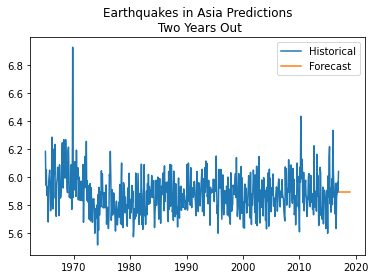

In [67]:
fig, ax = plt.subplots()

ax.plot(monthly_mean_asian, label='Historical')
ax.plot(forecast, label='Forecast')
ax.set_title('Earthquakes in Asia Predictions\n Two Years Out')

plt.legend();

## Trying a SARIMAX to hopefully introduce Lat/Long/Depth into the mix, rather than just Magnitude

In [68]:
# Setting up the different Series
monthly_lat = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Latitude'])).resample('MS').mean()
monthly_long = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Longitude'])).resample('MS').mean()
monthly_dep = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Depth'])).resample('MS').mean()

In [69]:
# Endogenous and Exogenous Variables:
endo = monthly_mean_asian # Magnitude
exo_lat = monthly_lat
exo_long = monthly_long
exo_dep = monthly_dep

In [70]:
# Fitting the models

mod_lat = SARIMAX(endo, exo_lat,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_long = SARIMAX(endo, exo_long,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_dep = SARIMAX(endo, exo_dep,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_lat_long = SARIMAX(exo_lat, exo_long, # exo_lat is the "endo" for this model
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

In [71]:
print(mod_lat.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  624
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 357.484
Date:                Thu, 02 Dec 2021   AIC                           -708.969
Time:                        21:31:04   BIC                           -695.675
Sample:                    01-01-1965   HQIC                          -703.801
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Latitude       0.0013      0.001      1.950      0.051   -6.56e-06       0.003
ma.L1         -1.0638      0.016    -66.899      0.000      -1.095      -1.033
sigma2         0.0163      0.001     23.804      0.0

In [72]:
print(mod_long.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  624
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 358.227
Date:                Thu, 02 Dec 2021   AIC                           -710.455
Time:                        21:31:04   BIC                           -697.161
Sample:                    01-01-1965   HQIC                          -705.288
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Longitude     -0.0011      0.000     -2.903      0.004      -0.002      -0.000
ma.L1         -0.9378      0.014    -65.159      0.000      -0.966      -0.910
sigma2         0.0184      0.001     23.119      0.0

In [73]:
print(mod_dep.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  624
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 355.590
Date:                Thu, 02 Dec 2021   AIC                           -705.180
Time:                        21:31:04   BIC                           -691.886
Sample:                    01-01-1965   HQIC                          -700.012
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Depth       -5.87e-05      0.000     -0.429      0.668      -0.000       0.000
ma.L1         -0.9392      0.014    -66.288      0.000      -0.967      -0.911
sigma2         0.0186      0.001     28.526      0.0

In [74]:
print(mod_lat_long.summary())

                               SARIMAX Results                                
Dep. Variable:               Latitude   No. Observations:                  624
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2168.664
Date:                Thu, 02 Dec 2021   AIC                           4343.327
Time:                        21:31:04   BIC                           4356.621
Sample:                    01-01-1965   HQIC                          4348.494
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Longitude      0.2238      0.019     11.760      0.000       0.187       0.261
ma.L1         -0.9599      0.012    -81.164      0.000      -0.983      -0.937
sigma2        63.0231      3.662     17.208      0.0

Trying the forecasting using the template from Amber's JN does not work with these exogenous variable models

In [75]:
# forecast_lat = mod_lat.forecast(steps=24)
# forecast_long = mod_long.forecast(steps=24)
# forecast_dep = mode_dep.forecast(steps=24)

Generate list of parameters to test for each SARIMAX model (Magnitude with either Latitude, Longitude or Depth.

In [76]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary'''
# p = d = q = range(0, 3) # Only run once to optimize
# pdq = list(itertools.product(p, d, q)) #
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameters for SARIMA...')
# for i in pdq:  ##  Only turn on when optimizing
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i, s))

'This was only run once to optimize.  Only uncomment if reoptimization necessary'

Finding Optimal SARIMAX parameters for endo='Magnitude', exo = 'Latitude'

In [77]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary
Optimized was (0,1,1),(0,0,0,12) -> aic = -712.00'''
# for param in pdq:  # Only run again if we need to re-optimize - Best is (0,1,1),(0,0,0,12), aic= -712.00
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(endo, exo_lat,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

'This was only run once to optimize.  Only uncomment if reoptimization necessary\nOptimized was (0,1,1),(0,0,0,12) -> aic = -712.00'

Finding Optimal SARIMAX parameters for endo='Magnitude', exo = 'Longitude'

In [78]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary
Optimized was (0,1,1),(0,0,0,12) -> aic = -712.59'''
# for param in pdq:  # Only run again if we need to re-optimize - Best is (0,1,1),(0,0,0,12), aic= -712.59
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(endo, exo_long,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

'This was only run once to optimize.  Only uncomment if reoptimization necessary\nOptimized was (0,1,1),(0,0,0,12) -> aic = -712.59'

Finding Optimal SARIMAX parameters for endo='Magnitude', exo = 'Depth'

In [79]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary
Optimized was (0,1,1),(0,0,0,12) -> aic = -707.65'''
# for param in pdq:  # Only run again if we need to re-optimize - Best is (0,1,1),(0,0,0,12), aic=-707.65
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(endo, exo_dep,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

'This was only run once to optimize.  Only uncomment if reoptimization necessary\nOptimized was (0,1,1),(0,0,0,12) -> aic = -707.65'

### Trying to make a model that uses Magnitude as the endogenous variable, with Latitude and Longitude as combined exogenous variables.  Might add Depth if that becomes a possibility as well, and time permits.

In [80]:
'''
Using info from the following link:
https://stackoverflow.com/questions/44212127/how-do-i-input-multiple-exogenous-variables-into-a-sarimax-model-in-statsmodel
to attempt multi-exogenous variable models.

It has you define the exogenous input as an array with dimensions nobsxk, where nobs = # observations
(ie, how many lines in the time-series data) and k is the number of additional exogenous variables.

'''
# nobs = len(endo)
# k = 2 # for adding lat and long
# emp = np.empty([nobs, k])
# arr = np.append(emp, np.array([[exo_lat][0], [exo_long][0]]).transpose(), axis=1)

# arr2 = np.array([[exo_lat][0], [exo_long][0]]).transpose()

# print(emp)
# print(len(emp))
# print(arr)
# print(len(arr))
# print(exo_lat[0],[exo_long[0]])
# print(len(exo_lat))
# print(arr2)
# print(len(endo))



'\nUsing info from the following link:\nhttps://stackoverflow.com/questions/44212127/how-do-i-input-multiple-exogenous-variables-into-a-sarimax-model-in-statsmodel\nto attempt multi-exogenous variable models.\n\nIt has you define the exogenous input as an array with dimensions nobsxk, where nobs = # observations\n(ie, how many lines in the time-series data) and k is the number of additional exogenous variables.\n\n'

# I don't think I can use monthly means for this, because Latitude and Longitude ranges over a month account for many earthquakes in different parts of asia.  I think the best I can do is use daily means instead.  This still will be prone to a certain amount of error (if there are two earthquakes on the same day in different parts of asia), but we'll just have to deal with that because this is the best I know how to do for now.

## Doing this for all of Asia is appearing to be very slow for the "grid search" process, so I will try just Japan and see how that goes.

In [81]:
df_japan = df_countries[df_countries['Country'] == 'Japan'].reset_index(drop=True)
df_japan = df_japan.drop(drop_extra, axis=1)
df_japan['Date_Time'] = pd.to_datetime(df_japan['Date_Time']).reset_index(drop=True)

### Toggle the cell below to use Japan data only (make sure to un-toggle the subsequent Markdown cell)

In [82]:
# Setting up the different Series
monthly_magn = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Magnitude'])).resample('MS').mean()
monthly_lat = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Latitude'])).resample('MS').mean()
monthly_long = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Longitude'])).resample('MS').mean()
monthly_dep = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Depth'])).resample('MS').mean()

### Toggle the cell below to use all Asia data (make sure to un-toggle the previous Markdown cell)

In [83]:
# daily_magn = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Magnitude'])).resample('D').mean()
# daily_lat = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Latitude'])).resample('D').mean()
# daily_long = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Longitude'])).resample('D').mean()
# daily_dep = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Depth'])).resample('D').mean()

Forward-Filling to fill in any missing months

In [84]:
endo = monthly_magn.ffill()
exo_lat = monthly_lat.ffill()
exo_long = monthly_long.ffill()
exo_dep = monthly_dep.ffill()

New train and test for the daily samples, we need to just use the last year of monthly means because it wasn't missing any values, and we need that to be the case for the test

In [85]:
train = endo[:-12]
test = endo[-12:]

In [86]:
# Fitting the models

mod = SARIMAX(endo,
              order=(0,1,1,),
              seasonal_order=(0,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False).fit()

mod_lat = SARIMAX(endo, exo_lat,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_long = SARIMAX(endo, exo_long,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_dep = SARIMAX(endo, exo_dep,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_lat_long = SARIMAX(exo_lat, exo_long, # exo_lat is the "endo" for this model
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

In [87]:
mod_list = [mod,mod_lat,mod_long,mod_dep,mod_lat_long]

In [88]:
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  623
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -43.460
Date:                Thu, 02 Dec 2021   AIC                             90.919
Time:                        21:31:06   BIC                             99.779
Sample:                    02-01-1965   HQIC                            94.363
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0520      0.015    -71.748      0.000      -1.081      -1.023
sigma2         0.0607      0.003     18.247      0.000       0.054       0.067
Ljung-Box (L1) (Q):                   6.89   Jarque-

In [89]:
for model in mod_list:
    print(model.summary())
    y_hat_train = model.predict(typ='levels')
    y_hat_train = y_hat_train[:-12]
    print(y_hat_train)
    y_hat_test = model.predict(start=test.index[0], end=test.index[-1], typ='levels')
    print(y_hat_test)
    rmse_train = np.sqrt(mean_squared_error(train,y_hat_train))
    rmse_test = np.sqrt(mean_squared_error(test,y_hat_test))
    print('train: ', rmse_train)
    print('test: ', rmse_test)
    print()

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  623
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -43.460
Date:                Thu, 02 Dec 2021   AIC                             90.919
Time:                        21:31:06   BIC                             99.779
Sample:                    02-01-1965   HQIC                            94.363
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0520      0.015    -71.748      0.000      -1.081      -1.023
sigma2         0.0607      0.003     18.247      0.000       0.054       0.067
Ljung-Box (L1) (Q):                   6.89   Jarque-

In [90]:
lat_long_array = np.array([[exo_lat][0], [exo_long][0]]).transpose()

In [91]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary'''
# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(0, 0, 0, 12)]
# print('Examples of parameters for SARIMA...')
# for i in pdq:
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i, s))

'This was only run once to optimize.  Only uncomment if reoptimization necessary'

In [92]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary
Optimized was (2,1,2),(0,0,0,365) -> aic = 4796.09'''
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(endo, lat_long_array,
#                          order=param,
#                          #seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

'This was only run once to optimize.  Only uncomment if reoptimization necessary\nOptimized was (2,1,2),(0,0,0,365) -> aic = 4796.09'

### The best AIC score was for (2,1,2) x (0,0,0,365) => 4796.09
#### Compared to the worst score for (0,0,0) x (0,0,0,365) => 21006.36

In [93]:
mod_lat_long = SARIMAX(endo, lat_long_array,
                       order = (2,1,2),
                       seasonal_order = (0,0,0,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit()

F:\Flatiron\Anaconda2\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [94]:
print(mod_lat_long.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  623
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -39.467
Date:                Thu, 02 Dec 2021   AIC                             92.933
Time:                        21:31:07   BIC                            123.930
Sample:                    02-01-1965   HQIC                           104.983
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0030      0.003      0.908      0.364      -0.003       0.009
x2            -0.0028      0.003     -0.891      0.373      -0.009       0.003
ar.L1         -0.3059      0.573     -0.534      0.5

In [95]:
mod_lat_long_alt = SARIMAX(endo, lat_long_array,
                       order = (0,1,1),
                       seasonal_order = (0,0,0,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit()

print(mod_lat_long_alt.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  623
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -43.269
Date:                Thu, 02 Dec 2021   AIC                             94.539
Time:                        21:31:07   BIC                            112.257
Sample:                    02-01-1965   HQIC                           101.426
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0023      0.003      0.716      0.474      -0.004       0.008
x2            -0.0018      0.003     -0.599      0.549      -0.008       0.004
ma.L1         -1.0514      0.015    -71.831      0.0

In [96]:
# New Train/Test:

daily_mean_asian = monthly_magn
cutoff = round(daily_mean_asian.shape[0] * 0.8)

In [97]:
train = daily_mean_asian[:cutoff]
test = daily_mean_asian[cutoff:]

Text(0.5, 1.0, 'Train/Test Split')

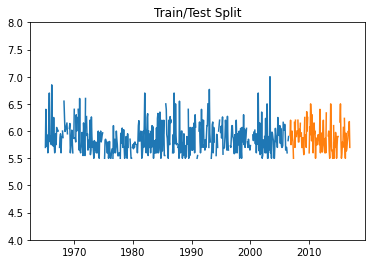

In [98]:
fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_ylim(4,8)
ax.set_title('Train/Test Split')

In [99]:
arimax_mod = SARIMAX(train,
                    order=(2,1,2),
                    seasonal_order=(0,0,0,365),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

In [100]:
arima_mod = SARIMAX(train,
                   order=(0,1,1),
                   seasonal_order=(0,0,0,365),
                   enforce_stationarity=False,
                   enforce_invertibility=False).fit()

In [101]:
print(arimax_mod.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  498
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -36.851
Date:                Thu, 02 Dec 2021   AIC                             83.702
Time:                        21:31:08   BIC                            104.715
Sample:                    02-01-1965   HQIC                            91.951
                         - 07-01-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4300      0.530     -0.811      0.418      -1.470       0.610
ar.L2         -0.0584      0.055     -1.056      0.291      -0.167       0.050
ma.L1         -0.5425      0.530     -1.024      0.3

Removing the contribution of Latitude/Longitude from the model produces an AIC about 1000 lower than the model which includes them.  The p-value also improve significantly:

In [102]:
print(arima_mod.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  498
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -37.323
Date:                Thu, 02 Dec 2021   AIC                             78.646
Time:                        21:31:08   BIC                             87.055
Sample:                    02-01-1965   HQIC                            81.947
                         - 07-01-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0446      0.017    -63.097      0.000      -1.077      -1.012
sigma2         0.0630      0.004     16.424      0.000       0.056       0.071
Ljung-Box (L1) (Q):                   0.01   Jarque-

So maybe this is the way to go?

We will continue with the location-adjusted model for now, but we will revisit the above if necessary.

In [118]:
y_hat_train = arimax_mod.predict(typ='levels')
y_hat_train = y_hat_train.ffill()
train = train.ffill()
print(y_hat_train)
print(train)
y_hat_test = arimax_mod.predict(start=test.index[0], end=test.index[-1], typ='levels')

rmse_train = np.sqrt(mean_squared_error(train,y_hat_train))
rmse_test = np.sqrt(mean_squared_error(test,y_hat_test))
print(rmse_train,' ',rmse_test)

Date_Time
1965-02-01    0.000000
1965-03-01    4.474523
1965-04-01    5.954730
1965-05-01    5.971524
1965-06-01    5.844443
                ...   
2006-03-01    5.887823
2006-04-01    5.869142
2006-05-01    5.862027
2006-06-01    5.860339
2006-07-01    5.844759
Freq: MS, Name: predicted_mean, Length: 498, dtype: float64
Date_Time
1965-05-01    5.800000
1965-06-01    5.927273
1965-07-01    5.600000
1965-08-01    5.700000
1965-09-01    6.200000
                ...   
2006-03-01    5.700000
2006-04-01    5.600000
2006-05-01    5.600000
2006-06-01    5.825000
2006-07-01    5.900000
Freq: MS, Name: Magnitude, Length: 495, dtype: float64


ValueError: Found input variables with inconsistent numbers of samples: [495, 498]

In [ ]:
stop

In [ ]:
fig, ax = plt.subplots()
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.plot(y_hat_train, label='Train Predicted')
ax.plot(y_hat_test, label='Test Predicted')
plt.legend();

In [ ]:
fig, ax = plt.subplots()

ax.plot(test, label='Actual')
ax.plot(y_hat_test, label='Predicted')
plt.legend();

In [ ]:
test = (pd.Series(temp_df.set_index(temp_df['Date_Time'])['Magnitude'])).resample('D').mean()
y_hat_test = (pd.Series(temp_df.set_index(temp_df['Date_Time'])['y_hat_test'])).resample('D').mean()

In [ ]:
np.sqrt(mean_squared_error(test.dropna(), y_hat_test.dropna()))

In [ ]:
arimax_mod = SARIMAX(daily_mean_asian,
                    order=(2,1,2),
                    seasonal_order=(0,0,0,365),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

In [ ]:
forecast = arimax_mod.forecast(steps=24)

In [ ]:
fig, ax = plt.subplots()

ax.plot(daily_mean_asian, label='Historical')
ax.plot(forecast, label='Forecast')
ax.set_title('Earthquakes in Asia Predictions \n Two Years Out')

plt.legend();